In [13]:
# Cell 1 — Imports & plotting defaults
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pathlib import Path

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (14,5)
sns.set_context("notebook")


In [14]:
# Cell 2 — Load data (adjust path if needed)
DATA_PATH = Path("Data/BANKNIFTY_FUT.csv")   # change path if your file is elsewhere
if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Place BANKNIFTY_FUT.csv at this location.")

df = pd.read_csv(DATA_PATH, dtype=str)
# normalize column names
df.columns = [c.strip() for c in df.columns]

# normalize spacing and parse datetime (dayfirst)
df['datetime_raw'] = df['datetime'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
df['datetime'] = pd.to_datetime(df['datetime_raw'], dayfirst=True, errors='coerce')

# convert numeric columns
for col in ['open','high','low','close','volume']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# quick diagnostics
print("Rows loaded:", len(df))
print("Datetime parse failures (NaT):", df['datetime'].isna().sum())
df.head(6)


Rows loaded: 289482
Datetime parse failures (NaT): 173758


,datetime,tradingsymbol,expiry,open,high,low,close,volume,datetime_raw
0,2021-01-07 09:15:00,BANKNIFTY21JULFUT,2021-07-29,34975.75,34996.70,34930.05,34941.05,32475.0,2021-07-01 09:15:00
1,2021-01-07 09:16:00,BANKNIFTY21JULFUT,2021-07-29,34952.45,34963.65,34924.25,34959.95,28100.0,2021-07-01 09:16:00
2,2021-01-07 09:17:00,BANKNIFTY21JULFUT,2021-07-29,34954.15,34977.65,34930.00,34930.00,21750.0,2021-07-01 09:17:00
3,2021-01-07 09:18:00,BANKNIFTY21JULFUT,2021-07-29,34930.00,34934.70,34901.70,34913.25,19650.0,2021-07-01 09:18:00
4,2021-01-07 09:19:00,BANKNIFTY21JULFUT,2021-07-29,34910.30,34929.85,34891.00,34920.00,17125.0,2021-07-01 09:19:00
5,2021-01-07 09:20:00,BANKNIFTY21JULFUT,2021-07-29,34920.00,34924.35,34871.15,34882.10,32675.0,2021-07-01 09:20:00


In [15]:
# Cell 3 — Extract EOD per calendar date using 15:30 cutoff (safe logic)
EOD_CUTOFF = "15:30"   # market cutoff for BankNifty (adjustable)

# ensure datetimes exist
df = df.dropna(subset=['datetime']).copy()

# compute seconds of day for each timestamp
df['sec_of_day'] = df['datetime'].dt.hour * 3600 + df['datetime'].dt.minute * 60 + df['datetime'].dt.second
# calendar date (date portion)
df['cal_date'] = df['datetime'].dt.date

# compute cutoff seconds
hh, mm = map(int, EOD_CUTOFF.split(":"))
cutoff_sec = hh * 3600 + mm * 60

# map each tick to a market_date:
# if tick.second_of_day <= cutoff -> belongs to same calendar date
# else -> assign to next calendar date (overnight)
df['market_date'] = pd.to_datetime(df['cal_date'])
after_mask = df['sec_of_day'] > cutoff_sec
df.loc[after_mask, 'market_date'] = df.loc[after_mask, 'market_date'] + pd.Timedelta(days=1)

# build eod_cutoff timestamp per market_date
df['eod_cutoff_ts'] = df['market_date'] + pd.to_timedelta(f"{EOD_CUTOFF}:00")

# keep ticks <= eod_cutoff_ts
valid = df[df['datetime'] <= df['eod_cutoff_ts']].copy()
if valid.empty:
    raise ValueError("No valid ticks found <= cutoff. Check timestamps or cutoff.")

# choose the last tick per market_date (closest to cutoff)
idx = valid.groupby('market_date')['datetime'].idxmax()
eod = valid.loc[idx, ['market_date', 'datetime', 'close']].copy().rename(columns={'close':'close_raw'})
eod['date'] = eod['market_date'].dt.date
eod = eod[['date','close_raw']].sort_values('date').reset_index(drop=True)

print("EOD rows extracted:", len(eod))
eod.head(8)


EOD rows extracted: 311


,date,close_raw
0,2021-01-07,34885.00
1,2021-01-09,36662.20
2,2021-01-10,37359.95
3,2021-01-11,40083.10
4,2021-01-12,36482.20
5,2021-02-07,34971.05
6,2021-02-08,34843.00
7,2021-02-09,37023.00


In [16]:
# Cell 4 — Prepare daily series (for plots we forward-fill missing calendar days)
series = eod.copy()
series['date'] = pd.to_datetime(series['date'])
series = series.set_index('date').asfreq('D')    # create calendar index (helps with smooth plots)
series['close'] = pd.to_numeric(series['close_raw'], errors='coerce')
# forward-fill for plotting continuity (visual only)
series['close'] = series['close'].ffill()

# compute MAs, returns, vol
series['ma7'] = series['close'].rolling(7).mean()
series['ma21'] = series['close'].rolling(21).mean()
series['returns'] = series['close'].pct_change()
series['vol_14'] = series['returns'].rolling(14).std() * math.sqrt(252)

series.head()


,close_raw,close,ma7,ma21,returns,vol_14
date,,,,,,
2021-01-07,34885.00,34885.00,NaN,NaN,NaN,NaN
2021-01-08,NaN,34885.00,NaN,NaN,0.000000,NaN
2021-01-09,36662.20,36662.20,NaN,NaN,0.050945,NaN
2021-01-10,37359.95,37359.95,NaN,NaN,0.019032,NaN
2021-01-11,40083.10,40083.10,NaN,NaN,0.072890,NaN


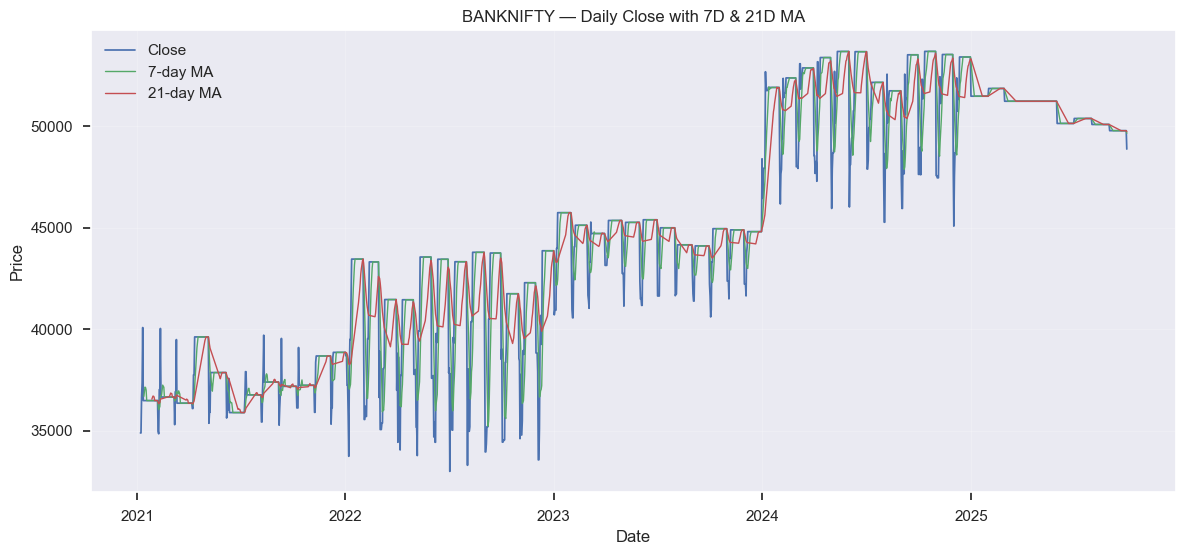

In [17]:
# Cell 5 — Price & Moving Averages
plt.figure(figsize=(14,6))
plt.plot(series.index, series['close'], label='Close', linewidth=1.25)
plt.plot(series.index, series['ma7'], label='7-day MA', linewidth=1)
plt.plot(series.index, series['ma21'], label='21-day MA', linewidth=1)
plt.title('BANKNIFTY — Daily Close with 7D & 21D MA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


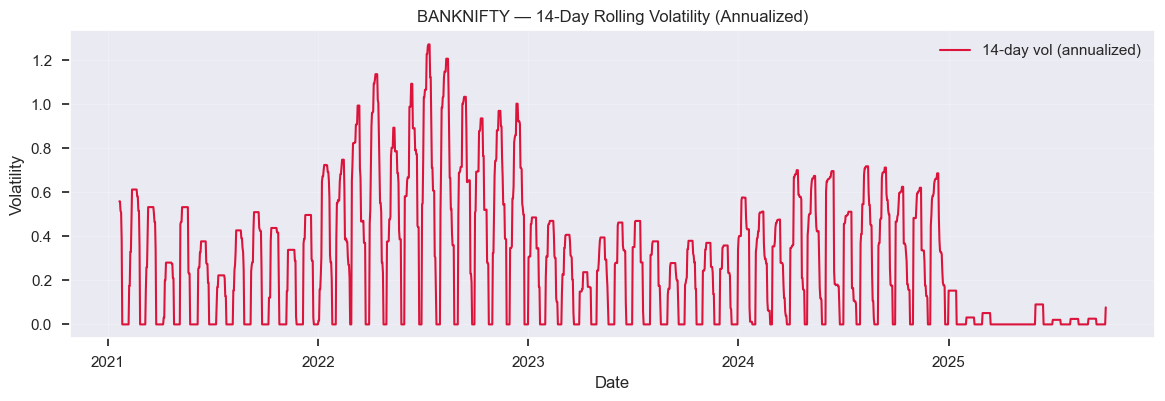

In [18]:
# Cell 6 — 14-day rolling volatility (annualized)
plt.figure(figsize=(14,4))
plt.plot(series.index, series['vol_14'], color='crimson', label='14-day vol (annualized)')
plt.title('BANKNIFTY — 14-Day Rolling Volatility (Annualized)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(alpha=0.2)
plt.legend()
plt.show()


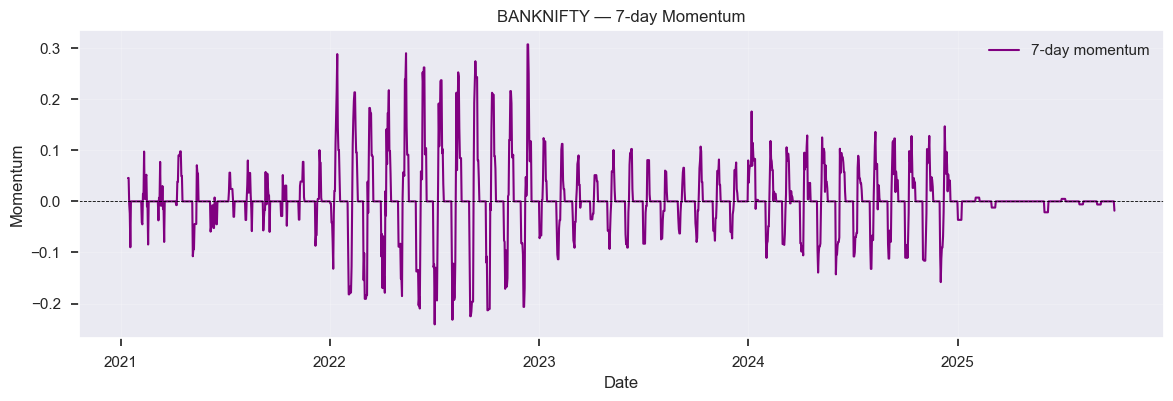

In [19]:
# Cell 7 — Momentum (7-day)
series['mom_7'] = series['close'] / series['close'].shift(7) - 1.0

plt.figure(figsize=(14,4))
plt.plot(series.index, series['mom_7'], label='7-day momentum', color='purple')
plt.axhline(0, color='black', linewidth=0.6, linestyle='--')
plt.title('BANKNIFTY — 7-day Momentum')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.grid(alpha=0.2)
plt.legend()
plt.show()


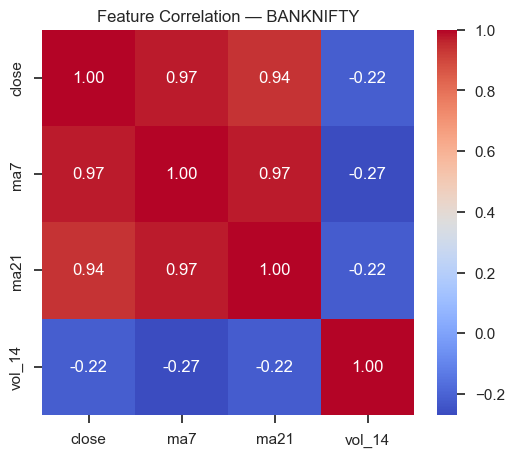

In [20]:
# Cell 8 — correlation heatmap between close, ma7, ma21, vol14
feat = series[['close','ma7','ma21','vol_14']].dropna()
plt.figure(figsize=(6,5))
sns.heatmap(feat.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation — BANKNIFTY')
plt.show()


In [23]:
# Cell 9 — Optional tiny baseline (updated & sklearn-safe)

try:
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    # prepare tabular lag features (last 7 closes)
    df_tab = series[['close']].copy().reset_index().rename(columns={'index':'date'})
    for lag in range(1, 8):
        df_tab[f'lag_{lag}'] = df_tab['close'].shift(lag)

    df_tab = df_tab.dropna().reset_index(drop=True)

    X = df_tab[[f'lag_{l}' for l in range(1,8)]].values
    # next-day close = shifted -1 and forward-fill safely
    y = df_tab['close'].shift(-1).ffill().values

    n = len(X)
    if n < 50:
        print("Not enough rows for baseline demo; skipping.")
    else:
        split = int(n * 0.8)
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        model = RandomForestRegressor(
            n_estimators=100, 
            random_state=42, 
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        # Metrics for older sklearn versions
        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        rmse = mse ** 0.5

        print("Baseline demo metrics:")
        print("MAE:", mae)
        print("RMSE:", rmse)

except Exception as ex:
    print("Baseline demo skipped (sklearn missing or error):", ex)


Baseline demo metrics:
MAE: 1371.5195401150727
RMSE: 1693.6802713119407


In [24]:
# Cell 10 — Final note for embedding/export
print("BANKNIFTY showcase ready.")
print("To export this notebook to HTML for embedding in React:")
print("jupyter nbconvert --to html your_notebook_filename.ipynb --output public/notebooks/banknifty_showcase.html")


BANKNIFTY showcase ready.
To export this notebook to HTML for embedding in React:
jupyter nbconvert --to html your_notebook_filename.ipynb --output public/notebooks/banknifty_showcase.html
